In [39]:
import os
import igraph
import pandas as pd
import numpy as np
from Scripts.Lab02 import helper_functions, similarity_measures, random_walk, supervised_random_walks
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

In [40]:
def read_graph_fromDF(path):
    # Load the graph from edgelist
    edgelist = pd.read_csv(path,sep=" ", header=None)
    edgelist.columns = ["source", "target"]
    # edgelist["label"] = "cites
    uniqueNodes = edgelist["source"].unique()
    numNodes = len(uniqueNodes)

    graph = igraph.Graph.DataFrame(edgelist,use_vids=True,directed=False)

    # directory = os.fsencode("data/facebook")
    # for file in os.listdir(directory):
    #     filename = os.fsdecode(file)
    #     vertName = filename.split(".")[0]
    #     print("vertName = ", vertName)
    #     if filename.endswith(".circles"):
    #
    #         max_feat = max(map(length,file.splitlines()))
    #         feature_names = ["c_{}".format(ii) for ii in range(max_feat)]
    #         update_df = pd.read_table("data/facebook/{}".format(filename),delimiter="\t",names=feature_names)

    return graph, numNodes #,node_data, feature_names
def read_graph(path):
    # Load the graph from edgelist
    edgelist = pd.read_csv(path,sep=" ", header=None, dtype=str)
    edgelist.columns = ["source", "target"]
    # edgelist["label"] = "cites
    uniqueNodes = edgelist["source"].unique()
    numNodes = len(uniqueNodes)
    graph = igraph.Graph()
    graph = igraph.Graph.DataFrame(edgelist,use_vids=True,directed=False)
    for node in uniqueNodes:
        graph.add_vertex(node)
    for index,row in edgelist.iterrows():
        try:
            graph.add_edge(row["source"],row["target"])
        except:
            graph.add_vertex(row["target"])
            graph.add_edge(row["source"],row["target"])
    return graph, numNodes #node_data, feature_names, numNodes

In [41]:
fbGraph, numNodes = read_graph_fromDF("data/facebook_combined.txt")
print("Number of nodes", numNodes)

Number of nodes 3663


In [42]:
# fbGraph.vs[0]
# fbGraph.vs[0]["circles"] = {"circle0": [0,13,2]}
# fbGraph.vs[0].attributes()
def length(line):
    return len(line.split('\t'))
directory = os.fsencode("data/facebook")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    vertName = int(filename.split(".")[0])
    if filename.endswith(".featnames"):
        print(filename)
        print(type(vertName))
        update_df = pd.read_csv("data/facebook/{}".format(filename),header=None,delimiter=" ",names=["feat_name","f","feat_num"])
        update_df[update_df.columns.difference(["f"])]
        break

0.featnames
<class 'int'>


In [43]:
def length(line):
    return len(line.split('\t'))
def feature_extraction(graph):
     # Load the features and subject for the node
    #  feature_names = ["w_{}".format(ii) for ii in range(1433)]
    directory = os.fsencode("data/facebook")
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        vertName = int(filename.split(".")[0])
        if filename.endswith(".circles"):
            with open("data/facebook/{}".format(filename)) as f:
                max_feat = max(map(length,f.readlines())) - 1
            feat = [ "c_{}".format(ii) for ii in range(max_feat)]
            feat_names = ["circle_name"] + feat
            df = pd.read_table("data/facebook/{}".format(filename),sep="\t",header=None,names=feat_names)
            graph.vs[vertName]["circles"] = df
        elif filename.endswith(".edges"):
            df = pd.read_csv("data/facebook/{}".format(filename),header=None,delimiter=" ",names=["source","target"])
            graph.vs[vertName]["edges"] = df
        elif filename.endswith(".egofeat"):
            df = pd.read_csv("data/facebook/{}".format(filename),header=None,delimiter=" ")
            graph.vs[vertName]["egoFeat"] = df
        elif filename.endswith(".feat"):
            update_df = pd.read_csv("data/facebook/{}".format(filename),header=None,delimiter=" ")
            graph.vs[vertName]["feat"] = update_df[update_df.columns.difference([0])]
        elif filename.endswith(".featnames"):
            update_df = pd.read_csv("data/facebook/{}".format(filename),header=None,delimiter=" ",names=["feat_name","f","feat_num"])
            graph.vs[vertName]["featnames"] = update_df[update_df.columns.difference(["f"])]
    return graph
    # column_names = feature_names + ["subject"]
    # node_data = pd.read_table("./data/cora/cora.content", header=None, names=column_names)

In [44]:
fbGraph, numNodes = read_graph_fromDF("data/facebook_combined.txt")
print("Number of nodes", numNodes)

Number of nodes 3663


In [45]:
feature_extraction(fbGraph)

Zad 1

In [46]:
train, test = helper_functions.split_data(fbGraph.es,0.2)
neg_samples = helper_functions.generate_negative_samples(fbGraph, len(test))
# test (prijateli) neg (not friends)

- Prediction score for Adamic - Adar

In [47]:
# Kako da go izvedam procesot na predviduvanje... Predviduvam koi jazli bi
def get_thresh(sim_measure='adamic_adar'):
    arr_measures = []
    for edge in train:
        nodeI, nodeJ = edge.vertex_tuple
        measure = similarity_measures.similarity(fbGraph,nodeI, nodeJ, sim_measure)
        arr_measures.append(measure)
    # # verojatnost da postoi vrska
    thresh = np.mean(arr_measures)
    threshNorm = np.median(arr_measures)
    print("MeanScore", thresh)
    print("MedianScore", threshNorm)
    return threshNorm
# print(roc_auc_score())
threshAdamic = get_thresh()
threshJacard = get_thresh('jaccard')
threshPrefAtt = get_thresh('preferential_attachment')

MeanScore 12.608529516454427
MedianScore 10.203311506065313
MeanScore 0.38238167508080484
MedianScore 0.36936936936936937
MeanScore 13563.779177841878
MedianScore 8384.0


In [48]:
import seaborn as sns

def pred_connections(sim_measure):
    if sim_measure == 'jaccard':
        threshNorm = threshJacard
    elif sim_measure == 'preferential_attachment':
        threshNorm = threshPrefAtt
    else:
        threshNorm = threshAdamic
    pred_set = []
    for edge in test:
        nodeI, nodeJ = edge.vertex_tuple
        measure = similarity_measures.similarity(fbGraph,nodeI, nodeJ, sim_measure)
        if measure >= threshNorm:
            pred_set.append(1)
        else:
            pred_set.append(0)
    for nodeI,nodeJ in neg_samples:
        measure = similarity_measures.similarity(fbGraph,nodeI, nodeJ, sim_measure)
        if measure >= threshNorm:
            pred_set.append(1)
        else:
            pred_set.append(0)
    return pred_set
def pred_scores(val, sim_measure = 'adamic_adar'):
    pred = pred_connections(sim_measure)
    roc_auc = roc_auc_score(val, pred)
    print("Roc_auc_score is: ", roc_auc)
    avg_prec = average_precision_score(val,pred)
    print("Average precision is: ", avg_prec)
    conf_matrix = confusion_matrix(val, pred)
    print("Confusion matrix:", conf_matrix)
    sns.heatmap(conf_matrix/ np.sum(conf_matrix), annot=True, fmt='.2%', cmap="Blues")

Roc_auc_score is:  0.7498301861160169
Average precision is:  0.7490203637947331
Confusion matrix: [[14698    24]
 [ 7342  7380]]


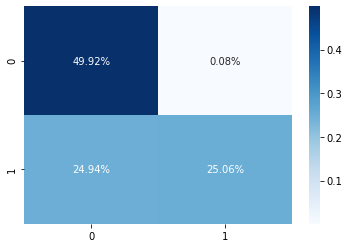

In [49]:
true_set = [1 for i in test] + [0 for i in neg_samples]
pred_scores(true_set, 'adamic_adar')

- Prediciton score for Jaccard

Roc_auc_score is:  0.7500679255535934
Average precision is:  0.7493587525034076
Confusion matrix: [[14701    21]
 [ 7338  7384]]


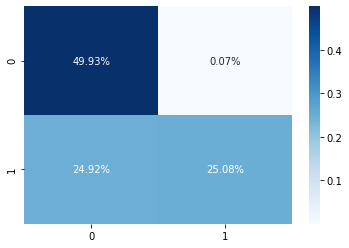

In [50]:
pred_scores(true_set, 'jaccard')


- Prediction score for Preferential attachment

Roc_auc_score is:  0.7312865099850563
Average precision is:  0.7139862328270833
Confusion matrix: [[14123   599]
 [ 7313  7409]]


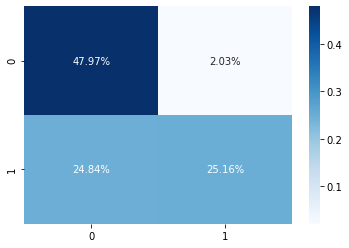

In [51]:
pred_scores(true_set, 'preferential_attachment')

### Random walk predictions

In [52]:
# fbGraph.adjacent(train[0].source_vertex)
adj_matrix = fbGraph.get_adjacency()
matrix_data = adj_matrix._get_data()

In [53]:
def getRW_thresh(train_set,matrix):
    prob_arr = []
    for edge in train_set:
        nodeI, nodeJ = edge.vertex_tuple
        p_arr = random_walk.random_walk(matrix,nodeI.index)
        prob = p_arr[nodeJ.index]
        prob_arr.append(prob)
    threshRW_mean = np.mean(prob_arr)
    print("Mean thresh: ",threshRW_mean)
    threshRW = np.median(prob_arr)
    return threshRW

In [54]:
def pred_connectionsRW(thresh):
    # threshRw = getRW_thresh(train, matrix_data)
    threshRw = thresh
    pred_set = []
    for edge in test:
        nodeI, nodeJ = edge.vertex_tuple
        p_arr = random_walk.random_walk(matrix_data, nodeI.index)
        prob = p_arr[nodeJ.index]
        if prob >= threshRw:
            pred_set.append(1)
        else:
            pred_set.append(0)
    for nodeI,nodeJ in neg_samples:
        p_arr = random_walk.random_walk(matrix_data, nodeI)
        prob = p_arr[nodeJ]
        if prob >= threshRw:
            pred_set.append(1)
        else:
            pred_set.append(0)
    return pred_set
def pred_scoresRW(val,thresh):
    pred = pred_connectionsRW(thresh)
    roc_auc = roc_auc_score(val, pred)
    print("Roc_auc_score is: ", roc_auc)
    avg_prec = average_precision_score(val,pred)
    print("Average precision is: ", avg_prec)
    conf_matrix = confusion_matrix(val, pred)
    print("Confusion matrix:", conf_matrix)
    sns.heatmap(conf_matrix/ np.sum(conf_matrix), annot=True, fmt='.2%', cmap="Blues")

- Prediction score for RandomWalk

In [ ]:
# 20 training edges for testing
THRESH = getRW_thresh(train[:20],matrix_data)

In [ ]:
pred_scoresRW(true_set,THRESH)


In [ ]:
def edge_features(sim_measure):
    # if sim_measure == 'jaccard':
    #     threshNorm = threshJacard
    # elif sim_measure == 'preferential_attachment':
    #     threshNorm = threshPrefAtt
    # else:
    #     threshNorm = threshAdamic
    for edge in train:
        nodeI, nodeJ = edge.vertex_tuple
        measure = similarity_measures.similarity(fbGraph,nodeI, nodeJ, sim_measure)
        edge[sim_measure] = measure
        fbGraph.es[edge.index][sim_measure] = measure
        # if measure >= threshNorm:
        #     pred_set.append(1)
        # else:
        #     pred_set.append(0)
    print(fbGraph.es[0])
    return
def pred_supervisedRW(val, sim_measures = ('adamic_adar','jaccard','preferential_attachment')):
    for measure_type in sim_measures:
        edge_features(measure_type)
    sources = []
    dest = []
    for edge in train:
        nodeI, nodeJ = edge.vertex_tuple
        sources.append(nodeI)
        dest.append(nodeJ)
    for nodeI,nodeJ in neg_samples:
        sources.append(nodeI)
        dest.append(nodeJ)
    result_dict = supervised_random_walks.supervised_random_walks(fbGraph,sources,dest)
    print(result_dict)